In [1]:
%pylab notebook
import os
import sys
import numpy as np
import matplotlib
try:
    import TimeTagger
except:
    print ("Time Tagger lib is not in the search path.")
    pyversion = sys.version_info
    from winreg import ConnectRegistry, OpenKey, HKEY_LOCAL_MACHINE, QueryValueEx
    registry_path = "SOFTWARE\\Python\\PythonCore\\" + str(pyversion.major) + "." + str(pyversion.minor) + "\\PythonPath\\Time Tagger"
    reg = ConnectRegistry(None, HKEY_LOCAL_MACHINE)
    key = OpenKey(reg, registry_path) 
    module_path = QueryValueEx(key,'')[0]
    print ("adding " + module_path)
    sys.path.append(module_path)
    
from TimeTagger import createTimeTagger, Combiner, Coincidence, Coincidences, Counter, Countrate, Correlation, Dump, TimeDifferences, TimeTagStream, Scope, Event, CHANNEL_UNUSED, UNKNOWN, LOW, HIGH

from time import sleep, time
from pylab import *
from datetime import datetime

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


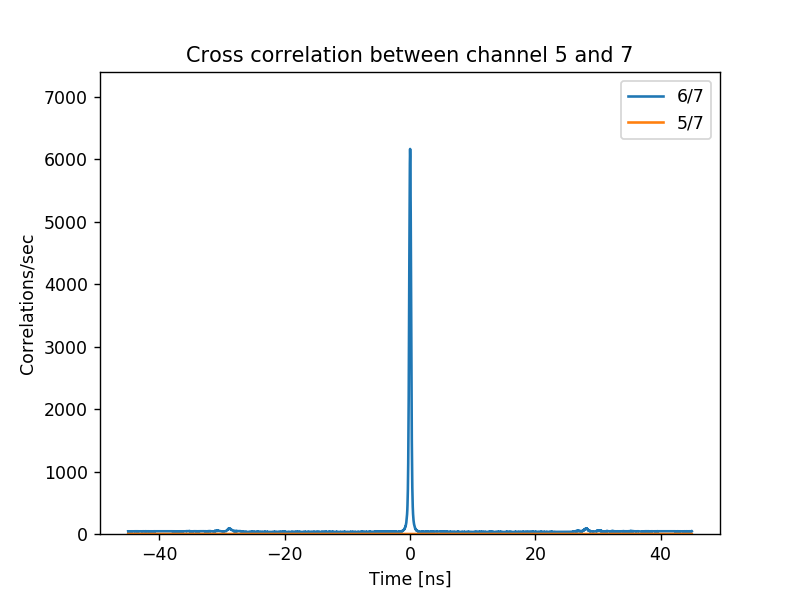

In [20]:
#script to run cross correlation 

# create a timetagger instance
tagger = createTimeTagger()
tagger.reset()


# Set the trigger level and deadtime for each channel
[tagger.setTriggerLevel(i, 0.5) for i in range(8)]
[tagger.setDeadtime(i, 6000) for i in range(8)]

binwidth_input = 3 #set the binwidth
binnumber = 30000 #set the number of bins

#delay the two beamsplit channels to coincide with zero time difference at the idler (correlation)
tagger.setInputDelay(channel=6,delay=-1098)#-3900)
tagger.setInputDelay(channel=5,delay=0)#-0, 2900)
tagger.setInputDelay(channel=7,delay=0)#15500, 0)
tagger.sync()

# cross correlation between channels 6 and 7, and 5 and 7
corr = Correlation(tagger, channel_1=6, channel_2=7, binwidth=binwidth_input, n_bins=binnumber)
corr1 = Correlation(tagger, channel_1=5, channel_2=7, binwidth=binwidth_input, n_bins=binnumber)
tstart = time.time()    # for profiling

sleep(1)
fig, ax = subplots(1, 1)
corr_plot, = plot(corr.getIndex()/1e3, corr.getData(), label= '6/7')
corr_plot1, = plot(corr1.getIndex()/1e3, corr1.getData(), label= '5/7')
xlabel('Time [ns]')
ylabel('Correlations/sec')
title('Cross correlation between channel 5 and 7')

legend()

In [21]:
while True:
# for i in range(measurementTime*3):
    corr_plot.set_ydata(corr.getData()/(time.time()-tstart))
    corr_plot1.set_ydata(corr1.getData()/(time.time()-tstart))
    fig.canvas.draw()
    ylim(0, 1.2*max(max(corr.getData()/(time.time()-tstart)),max(corr1.getData()/(time.time()-tstart))))
    time.sleep(0.02)
    

KeyboardInterrupt: 

In [22]:
save("20200811_1046_cross_correlation_nbins-30000_binwidth-3_signal2.npy", corr.getData())

<IPython.core.display.Javascript object>


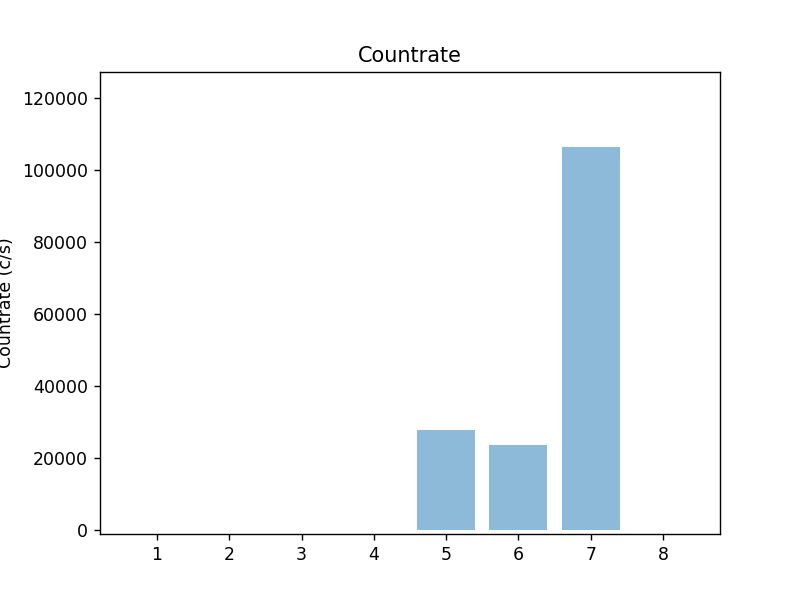

In [5]:
#Script to take countrate

# create a timetagger instance
tagger = createTimeTagger()
tagger.reset()

# Set the trigger level and deadtime for each channel
[tagger.setTriggerLevel(i, 0.5) for i in range(8)]
[tagger.setDeadtime(i, 6000) for i in range(8)]

measurementTime = 5 #time to measure in seconds

#set the channels to count
cr = Countrate( tagger, channels=[1,2,3,4,5,6,7,8] )
tagger.sync()

#wait and then start taking data
sleep(0.1)
data = cr.getData()

#set the labels for the axes
objects = ('1', '2', '3', '4', '5', '6', '7', '8')
y_pos = np.arange(len(objects))
tstart = time.time()

ion()
fig, ax = subplots(1, 1)
barg = bar(y_pos, data, align='center', alpha=0.5)
xticks(y_pos, objects)
ylabel('Countrate (c/s)')
title('Countrate')

for i in range(measurementTime):
    data = cr.getData()
    #barg = bar(y_pos, data, align='center', alpha=0.5)
    fig.canvas.draw()
    ylim(-1000, 1.2*max(cr.getData()))
    time.sleep(.05)

In [ ]:
#Script to run g2 measurement. 

#Create the time tagger instance
tagger = createTimeTagger()
tagger.reset()

# Set the trigger level and deadtime for each channel
[tagger.setTriggerLevel(i, 0.5) for i in range(8)]
[tagger.setDeadtime(i, 6000) for i in range(8)]

tagger.sync()

coincidenceWindow_ = 1000 # coincidence window in ps
iterant = 1000
noDataPoints = 7 #odd integer

inttime = 15*60 # integration time in s


# Delay channels to be coincident, using the web GUI to find the delay value
channelDelay_1 = -16100
channelDelay_2 = -20100
tagger.setInputDelay(channel=6,delay=(channelDelay_2))

#initialise the data variable
countersdata = np.zeros((noDataPoints,4))


print('Starting to take data.')
#iteratively offset the first channel to test g2 spectrum-wise
for i in range(noDataPoints):
    
    #print the time every time that the code loops
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("Current Time =", current_time)
    

    
    #Sweep down
    #print the time offset (tau) the loop is currently testing
    #print((channelDelay_1-i*iterant+int(noDataPoints/2)*iterant))
    #iteratively offset the first channel to test g2 spectrum-wise
    #tagger.setInputDelay(channel=5,delay=(channelDelay_1-i*iterant+int(noDataPoints/2)*iterant))
    #iteratively offset the second channel to test g2 spectrum-wise
    #tagger.setInputDelay(channel=6,delay=(channelDelay_2-i*iterant+int(noDataPoints/2)*iterant)) #comment out if sweeping only one channel

    #Sweep up
    #print the time offset (tau) the loop is currently testing
    print((channelDelay_1+i*iterant-int(noDataPoints/2)*iterant))
    #iteratively offset the first channel to test g2 spectrum-wise
    tagger.setInputDelay(channel=5,delay=(channelDelay_1+i*iterant-int(noDataPoints/2)*iterant))
    #iteratively offset the second channel to test g2 spectrum-wise
    #tagger.setInputDelay(channel=6,delay=(channelDelay_2+i*iterant-int(noDataPoints/2)*iterant)) #comment out if sweeping only one channel

    
    #prepare the coincidence channels to test
    C = Coincidences(tagger, [[5,7],[6,7],[5,6,7]], coincidenceWindow = coincidenceWindow_)
    coinc_chans = C.getChannels()
    S1 = coinc_chans[0] #double coincidence
    S2 = coinc_chans[1] #double coincidence
    C1 = coinc_chans[2] #triple coincidence
    
    #get the countrate for each channel
    sleep(0.5)
    counters = Countrate(tagger, [7, S1, S2, C1])
    
    #start counting
    tagger.sync()
    counters.start()
    sleep(inttime)
    counters.stop()
    countersdata[i] = counters.getData()
    
    #print the countrates
    print(countersdata[i])

#g2 is heralded coincidences times heralds divided by heralded singles times heralded singles
#g2 = countersdata[3]*countersdata[0]/(countersdata[1]*countersdata[2])

#g2 is heralded coincidences times heralds divided by heralded singles times heralded singles
g2 = np.divide(countersdata[:,0]*countersdata[:,3],(countersdata[:,1]*countersdata[:,2])) #this doesn't include the triple coincidence
print(g2)
sleep(0.5)
fig, ax = subplots(1, 1)
g2plot, = plot(g2)
xlabel('Time [ns]')
ylabel('g2')
title('g2 measurement')





Starting to take data.
Current Time = 11:30:16
-19100


In [143]:
#script to take raw time tagger data

# create a timetagger instance
tagger = createTimeTagger()
tagger.reset()


# Set the trigger level and deadtime for each channel
[tagger.setTriggerLevel(i, 0.5) for i in range(8)]
[tagger.setDeadtime(i, 6000) for i in range(8)]

#delay the two beamsplit channels to coincide with zero time difference at the idler (correlation)
tagger.setInputDelay(channel=6,delay=-20000)
tagger.setInputDelay(channel=5,delay=-16000)
tagger.sync()

import tempfile

tempdir = tempfile.gettempdir()
tmpfile = tempdir + os.sep + 'dump.tt'
print("1: Dump the data to " + tmpfile)
channels = [5, 6, 7]

# The number of maximum tags which should be dumped is limited only by the size of your storage device.
# Required space: tags * 16 byte
maximum_tags = 10**8
dump = Dump(tagger, tmpfile, maximum_tags, channels)
sleep(10*60)
print("Stop dumping and close the file.")
# by removing the measurement the output file is closed the dump stops
del dump
print("")
print("2: Load the data from " + tmpfile)
tagformat = np.dtype([('overflow', np.dtype('<u4')),
                      ('channel', np.dtype('<i4')), ('time', np.dtype('<u8'))])
data = np.fromfile(tmpfile, dtype=tagformat)

channel = data['channel'].astype('u1')
time = data['time']
channel, time

print("saving data")
save("channel.npy", channel)
save("times.npy", time)

print("Delete dump file.")
os.remove(tmpfile)



1: Dump the data to C:\Users\Davis\AppData\Local\Temp\dump.tt
Stop dumping and close the file.

2: Load the data from C:\Users\Davis\AppData\Local\Temp\dump.tt
saving data
Delete dump file.


Starting to take data.


<IPython.core.display.Javascript object>


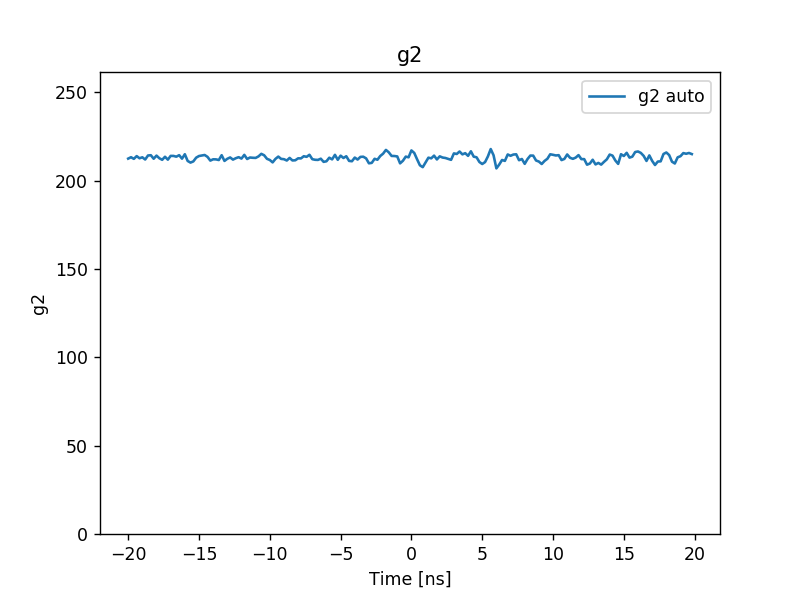

In [29]:
#Script to run autocorrelation (single photons?) g2 measurement.

#Create the time tagger instance
tagger = createTimeTagger()
tagger.reset()

# Set the trigger level and deadtime for each channel
[tagger.setTriggerLevel(i, 0.5) for i in range(8)]
[tagger.setDeadtime(i, 6000) for i in range(8)]

tagger.sync()

coincidenceWindow_ = 100 # coincidence window in ps
binwidth_input = 200 #bin width in ns
binnumber =200 #number of bins

# Delay channels to be coincident, using the web GUI to find the delay value
channelDelay_5 = -0
channelDelay_6 = -3900
channelDelay_7 = 15600

tagger.setInputDelay(channel=5,delay=(channelDelay_5))
tagger.setInputDelay(channel=6,delay=(channelDelay_6))
tagger.setInputDelay(channel=7,delay=(channelDelay_7))

print('Starting to take data.')

#Setting up coincidence channels
C = Coincidences(tagger, [[5,7],[6,7],[5,6,7],[5,6]], coincidenceWindow = coincidenceWindow_)
coinc_chans = C.getChannels()
S1 = coinc_chans[0] #double coincidence
S2 = coinc_chans[1] #double coincidence
S3 = coinc_chans[3] #double coincidence
C1 = coinc_chans[2] #triple coincidence

#getting countrates for channels
counters = Countrate(tagger, [5, 6, 7, S1, S2, C1])
corr_1 = Correlation(tagger, channel_1=7, channel_2=5, binwidth=binwidth_input, n_bins=binnumber)
corr_2 = Correlation(tagger, channel_1=7, channel_2=6, binwidth=binwidth_input, n_bins=binnumber)
corr_G = Correlation(tagger, channel_1=5, channel_2=6, binwidth=binwidth_input, n_bins=binnumber)

tstart = time.time()

tagger.sync()
counters.start()
countersdata_g2 = counters.getData()

#define the arrays used to calculated g2
#g2 is heralded coincidences times heralds divided by heralded singles times heralded singles
sleep(1)
array_1 = corr_1.getData()/(time.time()-tstart)
array_2 = corr_2.getData()/(time.time()-tstart)
array_g = corr_G.getData()/(time.time()-tstart)
g2 = array_g.astype(float)

fig, ax = subplots(1, 1)
corr_g2_plot, = plot(corr_G.getIndex()/1e3, g2, label='g2 auto')
#corr1plot, = plot(corr_1.getIndex()/1e3, corr1, label='corr1')
#corr2plot, =plot(corr_2.getIndex()/1e3, corr2, label='corr2')
xlabel('Time [ns]')
ylabel('g2')
title('g2')
legend()



In [30]:
while True:
# for i in range(measurementTime*3):
    countersdata_g2 = counters.getData()
    sleep(0.1)
    array_g = corr_G.getData()/(time.time()-tstart)
    array_1 = corr_1.getData()/(time.time()-tstart)
    array_2 = corr_2.getData()/(time.time()-tstart)
    g2 = array_g.astype(float)
    #corr1 = array_1.astype(float)
    #corr2 = array_2.astype(float)
    
    ymax = max(g2[np.isfinite(g2)])
    ax.set_ylim(0,1.2*ymax)
    
    fig.canvas.draw()
    corr_g2_plot.set_ydata(g2)
    #corr1plot.set_ydata(corr1)
    #corr2plot.set_ydata(corr2)

KeyboardInterrupt: 

Starting to take data.


<IPython.core.display.Javascript object>


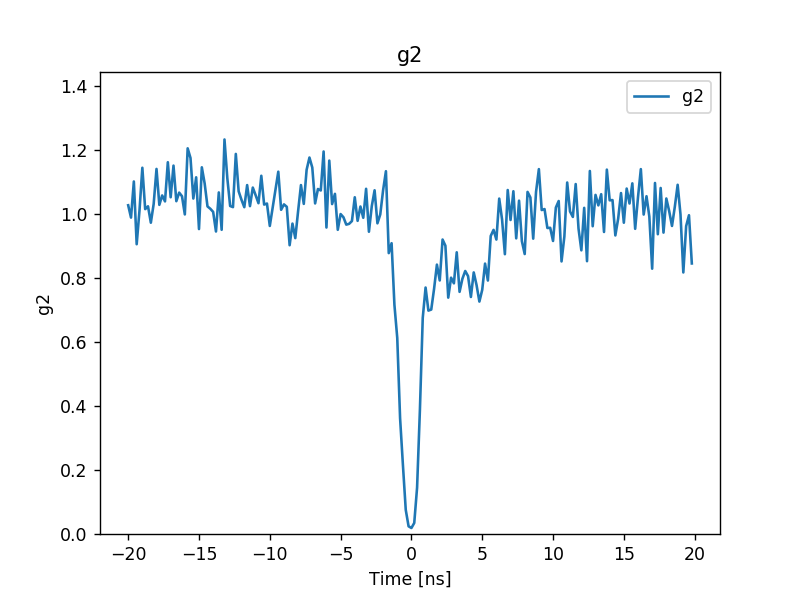

In [31]:
#Script to run heralded (single photons?) g2 measurement.

#Create the time tagger instance
tagger = createTimeTagger()
tagger.reset()

# Set the trigger level and deadtime for each channel
[tagger.setTriggerLevel(i, 0.5) for i in range(8)]
[tagger.setDeadtime(i, 6000) for i in range(8)]

tagger.sync()

coincidenceWindow_ = 1000 # coincidence window in ps
binwidth_input = 200 #bin width in ns
binnumber =200 #number of bins

# Delay channels to be coincident, using the web GUI to find the delay value
channelDelay_5 = -0
channelDelay_6 = -3900
channelDelay_7 = 15600

tagger.setInputDelay(channel=5,delay=(channelDelay_5))
tagger.setInputDelay(channel=6,delay=(channelDelay_6))
tagger.setInputDelay(channel=7,delay=(channelDelay_7))

print('Starting to take data.')

#Setting up coincidence channels
C = Coincidences(tagger, [[5,7],[6,7],[5,6,7],[5,6]], coincidenceWindow = coincidenceWindow_)
coinc_chans = C.getChannels()
S1 = coinc_chans[0] #double coincidence
S2 = coinc_chans[1] #double coincidence
S3 = coinc_chans[3] #double coincidence
C1 = coinc_chans[2] #triple coincidence

#getting countrates for channels
counters = Countrate(tagger, [5, 6, 7, S1, S2, C1])
corr_1 = Correlation(tagger, channel_1=7, channel_2=5, binwidth=binwidth_input, n_bins=binnumber)
corr_2 = Correlation(tagger, channel_1=7, channel_2=6, binwidth=binwidth_input, n_bins=binnumber)
corr_G = Correlation(tagger, channel_1=S1, channel_2=6, binwidth=binwidth_input, n_bins=binnumber)

tstart = time.time()

tagger.sync()
counters.start()
countersdata_g2 = counters.getData()

#define the arrays used to calculated g2
#g2 is heralded coincidences times heralds divided by heralded singles times heralded singles
sleep(1)
array_1 = corr_1.getData()/(time.time()-tstart)
array_2 = corr_2.getData()/(time.time()-tstart)
array_g = corr_G.getData()/(time.time()-tstart)
g2 = np.divide(countersdata_g2[2]*array_g.astype(float),(countersdata_g2[3]*array_2.astype(float)))
#g2 = np.divide(array_g.astype(float), np.sqrt(countersdata_g2[0]*countersdata_g2[1])) 
corr1 = array_1.astype(float)
corr2 = array_2.astype(float)

fig, ax = subplots(1, 1)
corr_g2_plot, = plot(corr_G.getIndex()/1e3, g2, label='g2')
#corr1plot, = plot(corr_1.getIndex()/1e3, corr1, label='corr1')
#corr2plot, =plot(corr_2.getIndex()/1e3, corr2, label='corr2')
xlabel('Time [ns]')
ylabel('g2')
title('g2')
legend()



In [ ]:
while True:
# for i in range(measurementTime*3):
    countersdata_g2 = counters.getData()
    sleep(0.1)
    array_g = corr_G.getData()/(time.time()-tstart)
    array_1 = corr_1.getData()/(time.time()-tstart)
    array_2 = corr_2.getData()/(time.time()-tstart)
    g2 = np.divide(countersdata_g2[2]*array_g.astype(float),(countersdata_g2[3]*array_2.astype(float)))
    #corr1 = array_1.astype(float)
    #corr2 = array_2.astype(float)
    
    ymax = max(g2[np.isfinite(g2)])
    ax.set_ylim(0,1.2*ymax)
    
    fig.canvas.draw()
    corr_g2_plot.set_ydata(g2)
    #corr1plot.set_ydata(corr1)
    #corr2plot.set_ydata(corr2)

In [106]:
print(countersdata_g2[2])
print(countersdata_g2[3])


1926770.6232116767
60376.99693662789


In [126]:
#save("20200804_1621_g2_heralded_200_binwidth_200_nbins.npy", g2)
print('done')

done


<IPython.core.display.Javascript object>


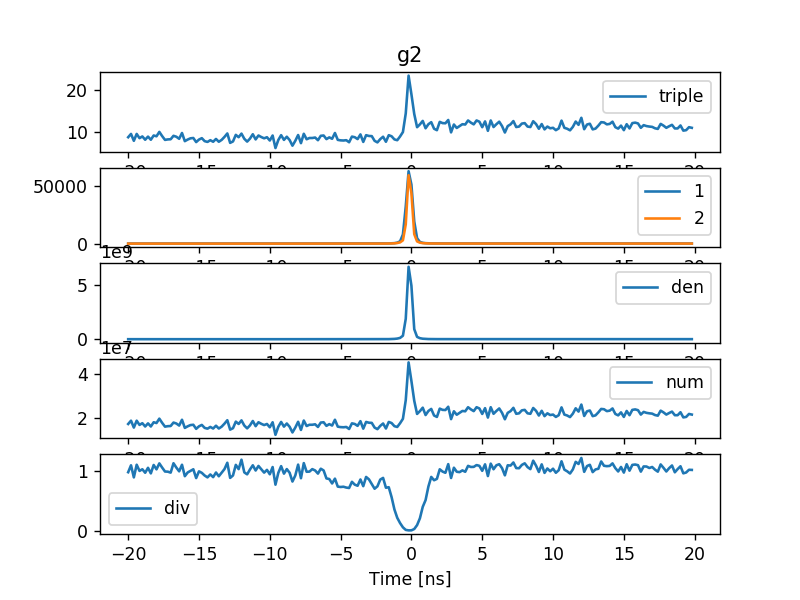

In [119]:
fig, ax = subplots(5, 1)
ax[1].plot(corr_G.getIndex()/1e3, array_1.astype(float), label='1')
ax[1].plot(corr_G.getIndex()/1e3, array_2.astype(float), label='2')
ax[0].plot(corr_G.getIndex()/1e3, array_g.astype(float), label='triple')
ax[2].plot(corr_G.getIndex()/1e3, countersdata_g2[3]*array_2.astype(float), label='den')
ax[3].plot(corr_G.getIndex()/1e3, countersdata_g2[2]*array_g.astype(float), label='num')
ax[4].plot(corr_G.getIndex()/1e3, np.divide((countersdata_g2[2]*array_g.astype(float)),(countersdata_g2[3]*array_2.astype(float))), label='div')

ax[4].set_xlabel('Time [ns]')
ax[0].set_title('g2')
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
ax[4].legend()

In [92]:
print(countersdata_g2[3])
print(countersdata_g2[2])

158176.31210030662
1941902.691367299


Starting to take data.


<IPython.core.display.Javascript object>


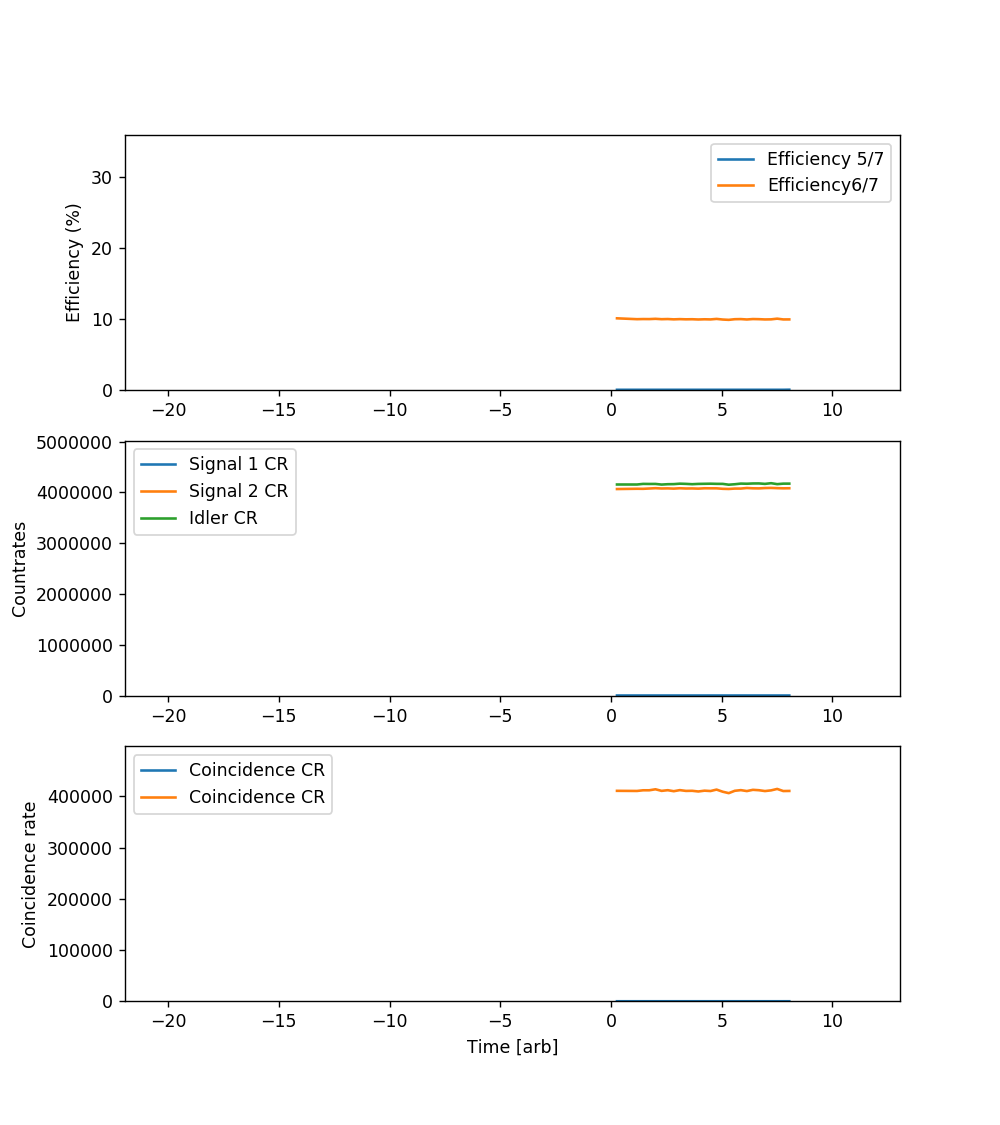

In [459]:
#efficiency

#Create the time tagger instance
tagger = createTimeTagger()
tagger.reset()

# Set the trigger level and deadtime for each channel
[tagger.setTriggerLevel(i, 0.5) for i in range(8)]
[tagger.setDeadtime(i, 6000) for i in range(8)]

tagger.sync()

coincidenceWindow_1 = 100 # coincidence window in ps
int_time = .2 # integration time in s
binwidth_input = 1000 #bin width in ns
binnumber = 100 #number of bins

# Delay channels to be coincident, using the web GUI to find the delay valueS
tagger.setInputDelay(channel=6,delay=-1098)#-4020)
tagger.setInputDelay(channel=5,delay=0)#-0, 2900)
tagger.setInputDelay(channel=7,delay=0)#15500, 0)


print('Starting to take data.')

#Setting up coincidence channels
C = Coincidences(tagger, [[5,7],[6,7],[5,6,7],[5,6]], coincidenceWindow = coincidenceWindow_1 )
coinc_chans = C.getChannels()
C1 = coinc_chans[0] #double coincidence
C2 = coinc_chans[1] #double coincidence

#getting countrates for channels
counters = Countrate(tagger, [5, 6, 7, C1, C2])

tstart = time.time()

tagger.sync()
counters.start()
sleep(int_time)
counters.stop()
countersdata_coincidence = counters.getData()
x_array = [time.time()-tstart]
y_array_E1 = [np.divide(countersdata_coincidence[3]*100, np.sqrt(countersdata_coincidence[0]*countersdata_coincidence[1]))]
y_array_E2 = [np.divide(countersdata_coincidence[4]*100, np.sqrt(countersdata_coincidence[1]*countersdata_coincidence[1]))]
y_array_S1 = [countersdata_coincidence[0]]
y_array_S2 = [countersdata_coincidence[1]]
y_array_I = [countersdata_coincidence[2]]
y_array_C1 = [countersdata_coincidence[3]]
y_array_C2 = [countersdata_coincidence[4]]

fig = plt.figure(figsize = (8,9), frameon=False)

ax1=plt.subplot(3,1,1)
p1a, = ax1.plot(x_array,y_array_E1, label='Efficiency 5/7')
p1b, = ax1.plot(x_array,y_array_E2, label='Efficiency6/7')

ax2=plt.subplot(3,1,2)
p2a, = ax2.plot(x_array,y_array_S1, label='Signal 1 CR')
p2b, = ax2.plot(x_array,y_array_S2, label='Signal 2 CR')
p3, = ax2.plot(x_array,y_array_I, label='Idler CR')

ax3=plt.subplot(3,1,3)
p4a, = ax3.plot(x_array,y_array_C1, label='Coincidence CR')
p4b, = ax3.plot(x_array,y_array_C2, label='Coincidence CR')
ax3.set_xlabel('Time [arb]')
ax1.set_ylabel('Efficiency (%)')
ax2.set_ylabel('Countrates')
ax3.set_ylabel('Coincidence rate')

ax1.legend()
ax2.legend()
ax3.legend()


In [460]:
while 1:
# for i in range(measurementTime*3):
    counters.start()
    sleep(int_time)
    counters.stop()
    countersdata_coincidence = counters.getData()
    x_array.append(time.time()-tstart)
    y_array_E1.append(np.divide(countersdata_coincidence[3]*100, np.sqrt(countersdata_coincidence[0]*countersdata_coincidence[2])))
    y_array_E2.append(np.divide(countersdata_coincidence[4]*100, np.sqrt(countersdata_coincidence[1]*countersdata_coincidence[2])))
    y_array_S1.append(countersdata_coincidence[0])
    y_array_S2.append(countersdata_coincidence[1])
    y_array_I.append(countersdata_coincidence[2])
    y_array_C1.append(countersdata_coincidence[3])
    y_array_C2.append(countersdata_coincidence[4])
    

    ymax1 = 30#max(y_array_E)
    ymax2 = max(max(y_array_S1), max(y_array_I), max(y_array_S2))
    ymax3 = max(max(y_array_C1),max(y_array_C2))
    xmax = max(x_array)
    ax1.set_ylim(0,1.2*ymax1)
    ax1.set_xlim(xmax - 30,xmax+5)
    ax2.set_xlim(xmax - 30,xmax+5)
    ax3.set_xlim(xmax - 30,xmax+5)
    
    fig.canvas.draw()
    p1a.set_ydata(y_array_E1)
    p1b.set_ydata(y_array_E2)
    p1a.set_xdata(x_array)
    p1b.set_xdata(x_array)
    ax2.set_ylim(0,1.2*ymax2)
    p2a.set_ydata(y_array_S1)
    p2b.set_ydata(y_array_S2)
    p2a.set_xdata(x_array)
    p2b.set_xdata(x_array)
    p3.set_ydata(y_array_I)
    p3.set_xdata(x_array)
    
    ax3.set_ylim(0,1.2*ymax3)
    p4a.set_ydata(y_array_C1)
    p4a.set_xdata(x_array)
    p4b.set_ydata(y_array_C2)
    p4b.set_xdata(x_array)

KeyboardInterrupt: 

In [475]:
#efficiency
#Create the time tagger instance
tagger = createTimeTagger()
tagger.reset()

# Set the trigger level and deadtime for each channel
[tagger.setTriggerLevel(i, 0.5) for i in range(8)]
[tagger.setDeadtime(i, 6000) for i in range(8)]


print('Starting to take data.')

for i in range(100):

    tagger.sync()

    coincidenceWindow_1 = 1000 #coincidence window in ps
    int_time = .1 # integration time in s
    binwidth_input = coincidenceWindow_1 #bin width in ns
    binnumber = 100 #number of bins

    # Delay channels to be coincident, using the web GUI to find the delay valueS
    tagger.setInputDelay(channel=6,delay=-1098)#-4020)
    tagger.setInputDelay(channel=5,delay=0)#-0, 2900)
    tagger.setInputDelay(channel=7,delay=0)#15500, 0)


    #Setting up coincidence channels
    C = Coincidences(tagger, [[5,7],[6,7],[5,6,7],[5,6]], coincidenceWindow = coincidenceWindow_1 )
    coinc_chans = C.getChannels()
    C1 = coinc_chans[0] #double coincidence
    C2 = coinc_chans[1] #double coincidence

    #getting countrates for channels
    counters = Countrate(tagger, [5, 6, 7, C1, C2])

    tstart = time.time()

    tagger.sync()
    counters.start()
    sleep(int_time)
    counters.stop()
    countersdata_coincidence = counters.getData()
    x_array = [time.time()-tstart]
    y_array_E1 = [np.divide(countersdata_coincidence[3]*100, np.sqrt(countersdata_coincidence[0]*countersdata_coincidence[1]))]
    y_array_E2 = [np.divide(countersdata_coincidence[4]*100, np.sqrt(countersdata_coincidence[1]*countersdata_coincidence[1]))]
    y_array_S1 = [countersdata_coincidence[0]]
    y_array_S2 = [countersdata_coincidence[1]]
    y_array_I = [countersdata_coincidence[2]]
    y_array_C1 = [countersdata_coincidence[3]]
    y_array_C2 = [countersdata_coincidence[4]]

    while time.time()-tstart < 2:
    # for i in range(measurementTime*3):
        counters.start()
        sleep(int_time)
        counters.stop()
        countersdata_coincidence = counters.getData()
        x_array.append(time.time()-tstart)
        y_array_E1.append(np.divide(countersdata_coincidence[3]*100, np.sqrt(countersdata_coincidence[0]*countersdata_coincidence[2])))
        y_array_E2.append(np.divide(countersdata_coincidence[4]*100, np.sqrt(countersdata_coincidence[1]*countersdata_coincidence[2])))
        y_array_S1.append(countersdata_coincidence[0])
        y_array_S2.append(countersdata_coincidence[1])
        y_array_I.append(countersdata_coincidence[2])
        y_array_C1.append(countersdata_coincidence[3])
        y_array_C2.append(countersdata_coincidence[4])

    total.append(array([mean(y_array_S2), mean(y_array_I), mean(y_array_C2) ,mean(y_array_E2)]))
    
print('done')

Starting to take data.


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


done


In [431]:

print(mean(y_array_E2))
print(mean(y_array_S2))
print(mean(y_array_I))
print(mean(y_array_C2))

0.566616167854939
317070.96047868987
76435.8973426623
984.8787769482008


In [407]:
len(total)

11

In [474]:
total = []

In [477]:
save("20200811_1708_binwidth_iter_nbins100_binwidth20.npy", total)

<IPython.core.display.Javascript object>


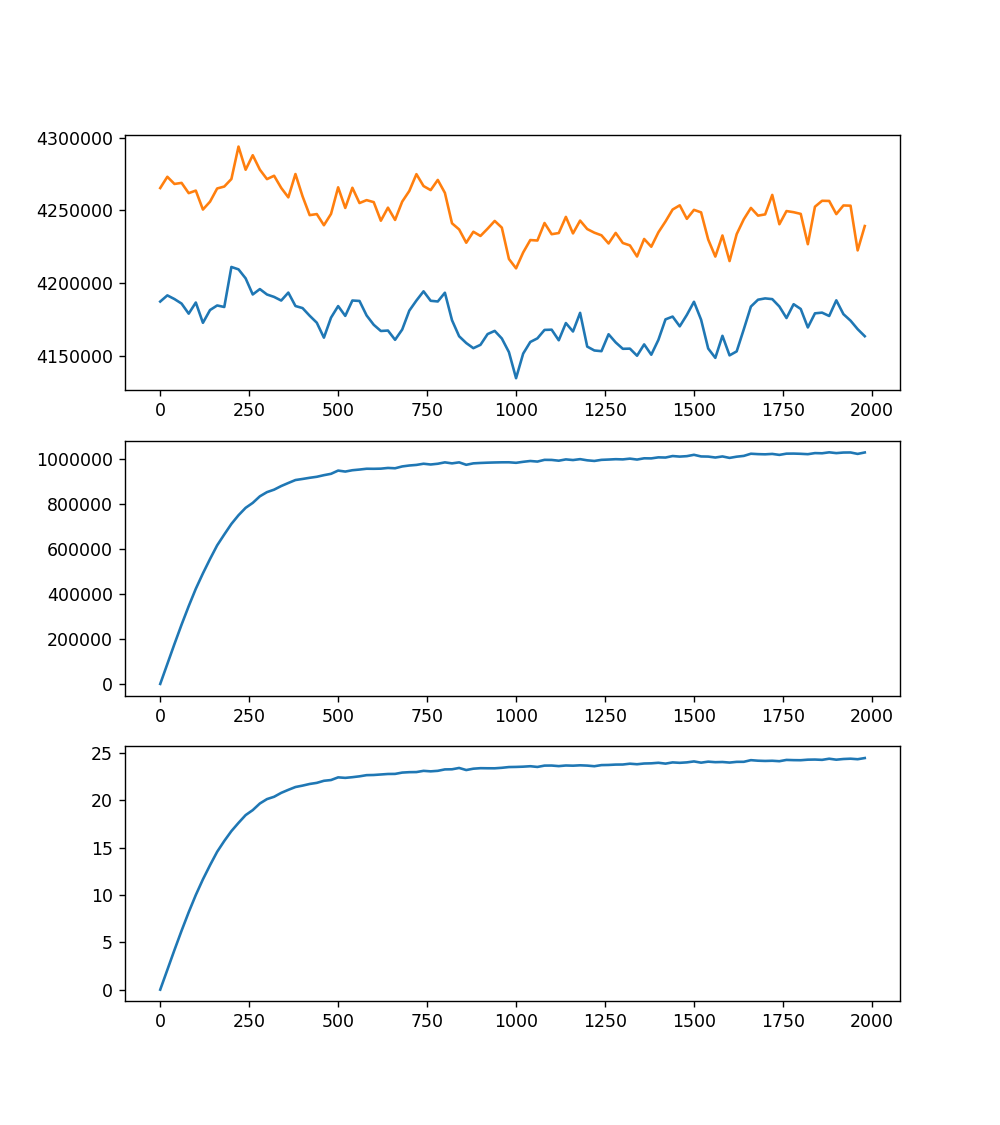

In [476]:
fig = plt.figure(figsize = (8,9), frameon=False)
total_new = array(total)
ax1=plt.subplot(3,1,1)
start = 0
iteration = 20

p1a, = ax1.plot(linspace(start, (len(total_new)-1)*iteration+start, len(total_new)),total_new[:,0], label='CR1')
p1b, = ax1.plot(linspace(start, (len(total_new)-1)*iteration+start, len(total_new)),total_new[:,1], label='CR2')

ax2=plt.subplot(3,1,2)

p2, = ax2.plot(linspace(start, (len(total_new)-1)*iteration+start, len(total_new)),total_new[:,2], label='Coin')

ax3=plt.subplot(3,1,3)

p3, = ax3.plot(linspace(start, (len(total_new)-1)*iteration+start, len(total_new)),total_new[:,3], label='klyshko')

                        


In [177]:
total

array([[2.67819431e+06, 2.78616872e+06, 6.51758187e+05, 2.38812516e+01],
       [1.81796712e+06, 1.89221963e+06, 4.52022126e+05, 2.43956134e+01],
       [1.07838707e+06, 1.12027333e+06, 2.74545243e+05, 2.50004553e+01],
       [8.48716389e+05, 8.81072563e+05, 2.19346675e+05, 2.53898053e+01],
       [1.22693380e+06, 1.27481241e+06, 3.14287465e+05, 2.51552918e+01],
       [2.08472826e+06, 2.16464993e+06, 5.20552757e+05, 2.45281118e+01],
       [2.92528754e+06, 3.03380653e+06, 7.12678205e+05, 2.39438300e+01],
       [3.28448612e+06, 3.40136398e+06, 7.90585305e+05, 2.36747602e+01],
       [3.11920608e+06, 3.23344527e+06, 7.53177503e+05, 2.37381205e+01],
       [2.48249917e+06, 2.58021516e+06, 6.07241958e+05, 2.40170885e+01],
       [1.52756045e+06, 1.59173768e+06, 3.81711347e+05, 2.45064653e+01],
       [9.05415243e+05, 9.42687192e+05, 2.31386495e+05, 2.50709509e+01],
       [8.14411843e+05, 8.44745933e+05, 2.10661486e+05, 2.54241886e+01],
       [1.30385473e+06, 1.35704842e+06, 3.32631091e